# SAM8905 Hardware Test - WF Bit Verification

## Purpose

Generate test algorithms to verify the WF bit layout on real SAM8905 hardware.

## Questions to Answer

1. **R/I bit positions**: Is R at bit 7 and I at bit 6 (per manual), or swapped (as in working emulation)?
2. **I bit semantics**: Does I=0 mean "direct output" or "apply transformation"?
3. **Invert operation**: Is it two's complement (-x), one's complement (~x), or something else?

## Test Strategy

Generate distinct waveforms for each WF configuration and record the audio output from real hardware. Compare against emulator predictions to determine correct bit layout.

## WF Bit Layout (from programmer's guide)

```
WF[8:0] = { INT, SEL[1:0], R, I, PHI_SEL[3:0] }

Bit 8 (INT): 0=External (ROM/SRAM), 1=Internal waveform
Bits 7-6 (SEL): Waveform select for internal mode
Bit 5 (R): Reverse (play backwards)?
Bit 4 (I): Invert?
Bits 3-0: PHI address select
```

But emulation works with R/I swapped. These tests will determine the correct layout.

In [13]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from sam8905_interpreter import SAM8905Interpreter, plot_waveform, export_wav, print_state
from sam8905_aram_decoder import decode_algorithm, decode_instruction
from sam8905_assembler import SAM8905Assembler, make_dram_word, make_amplitude_word, make_phase_increment

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 4)

print("Modules loaded")

Modules loaded


In [14]:
# Helper functions for test algorithm generation
# Based on sam8905.cpp get_waveform (working implementation)

def make_wf_word(internal=True, ramp_mode=False, invert=False, sel=0, z_bit=False):
    """Create WF register value.
    
    WF bit layout (from sam8905.cpp working implementation):
        WF[8]   = INT/EXT (1=internal waveform, 0=external SRAM)
        WF[7]   = I (invert: 0=direct, 1=two's complement)
        WF[6]   = R (ramp mode: 0=sinus, 1=ramp/constant)
        WF[5:4] = SEL (ramp type select, only used when R=1)
                  0 = 2x PHI triangle wave
                  1 = Constant from MAD (micro-instruction address)
                  2 = PHI ramp (sawtooth)
                  3 = PHI/2 ramp
        WF[3]   = Z (zero: if set, output is always 0)
        WF[2:0] = unused
    
    Args:
        internal: True for internal waveforms, False for external SRAM
        ramp_mode: False=sinus wave, True=ramp/constant (type set by sel)
        invert: False=direct output, True=two's complement negation
        sel: 2-bit ramp type (0-3), only used when ramp_mode=True
        z_bit: If True, output is always 0 (mute)
        
    Returns:
        9-bit WF value
    """
    wf = 0
    if internal:
        wf |= 0x100           # Bit 8: INT/EXT
    if invert:
        wf |= 0x80            # Bit 7: I (invert)
    if ramp_mode:
        wf |= 0x40            # Bit 6: R (ramp mode)
    wf |= (sel & 3) << 4      # Bits 5:4: SEL
    if z_bit:
        wf |= 0x08            # Bit 3: Z (zero output)
    # Bits 2:0 are unused
    return wf

def make_wf_config_dram(wf_value):
    """Create D-RAM word that sets WF via WWF instruction.
    
    WWF reads bus[17:9] as the 9-bit WF value.
    """
    return (wf_value & 0x1FF) << 9

def make_test_algorithm(wf_value, freq_hz=440, sample_rate=44100, algorithm_size=32):
    """Create a minimal test algorithm that outputs a waveform.
    
    Algorithm:
        D[0] = PHI (phase accumulator)
        D[1] = DPHI (phase increment) 
        D[2] = WF config (for WWF)
        D[3] = Amplitude + mix
        
        PC00: RM 2, <WWF>           ; Set WF register
        PC01: RM 0, <WA, WPHI>      ; A = PHI, set PHI register
        PC02: RM 1, <WB>            ; B = DPHI
        PC03: RM 3, <WXY, WSP>      ; X = waveform(PHI), Y = AMP, set mix
        PC04: RADD 0, <WM>          ; D[0] = PHI + DPHI
        PC05: RSP                   ; Wait for multiplier
        PC06: RSP, <WACC>           ; Accumulate to output
        PC07-31: NOP
    """
    asm = SAM8905Assembler(algorithm_size=algorithm_size)
    
    source = """
    WF_CFG=2
    PHI=0
    DPHI=1
    AMP=3
    
    RM      WF_CFG, <WWF>           ; Set WF register from D[2]
    RM      PHI,    <WA, WPHI>      ; A = D[0], PHI reg = D[0]
    RM      DPHI,   <WB>            ; B = D[1] (phase increment)
    RM      AMP,    <WXY, WSP>      ; X = waveform, Y = amplitude, set mix
    RADD    PHI,    <WM>            ; D[0] = A + B (update phase)
    RSP                             ; Wait for multiplier (cycle 1)
    RSP                             ; Wait for multiplier (cycle 2)
    RSP             , <WACC>        ; Accumulate result
    FIN
    """
    
    words, errors = asm.assemble(source)
    if errors:
        print(f"Assembly errors: {errors}")
        return None, None
    
    # Create D-RAM
    phase_inc = make_phase_increment(freq_hz, sample_rate)
    amplitude = 0x400  # Moderate amplitude
    mix_l, mix_r = 7, 7  # Full volume (7 = 0dB attenuation)
    
    dram = [0] * 16
    dram[0] = 0  # PHI starts at 0
    dram[1] = phase_inc << 7  # DPHI (goes to Y via bus[18:7])
    dram[2] = make_wf_config_dram(wf_value)  # WF config
    dram[3] = make_amplitude_word(amplitude, mix_l, mix_r)  # Amplitude + mix
    dram[15] = 0  # ALG=0, IDLE=0
    
    return words, dram

print("Helper functions defined (corrected WF bit layout)")
print()
print("WF bit layout:")
print("  [8]   = INT/EXT (1=internal)")
print("  [7]   = I (invert)")
print("  [6]   = R (ramp mode)")
print("  [5:4] = SEL (ramp type)")
print("  [3]   = Z (zero output)")
print("  [2:0] = unused")

Helper functions defined (corrected WF bit layout)

WF bit layout:
  [8]   = INT/EXT (1=internal)
  [7]   = I (invert)
  [6]   = R (ramp mode)
  [5:4] = SEL (ramp type)
  [3]   = Z (zero output)
  [2:0] = unused


## Test Configurations

We'll test the internal sine waveform (SEL=0) with different R/I bit combinations:

| Test | WF Value | R | I | Expected Output (if manual correct) | Expected (if R/I swapped) |
|------|----------|---|---|-------------------------------------|---------------------------|
| 1    | 0x100    | 0 | 0 | Normal sine                         | Normal sine               |
| 2    | 0x110    | 0 | 1 | Inverted sine                       | Reversed sine             |
| 3    | 0x120    | 1 | 0 | Reversed sine                       | Inverted sine             |
| 4    | 0x130    | 1 | 1 | Reversed + Inverted                 | Reversed + Inverted       |

By comparing real hardware output to these predictions, we can determine the correct bit layout.

In [37]:
# Define test configurations using make_wf_word for correctness
# Testing the R (ramp mode) and I (invert) bits

test_configs = [
    # {
    #     "name": "Test 1: Sinus (R=0, I=0)",
    #     "wf": make_wf_word(internal=True, ramp_mode=False, invert=False, sel=0),
    #     "ramp": False, "invert": False,
    #     "expected": "Pure sine wave"
    # },
    # {
    #     "name": "Test 2: Sinus Inverted (R=0, I=1)",
    #     "wf": make_wf_word(internal=True, ramp_mode=False, invert=True, sel=0),
    #     "ramp": False, "invert": True,
    #     "expected": "Sine wave with phase inverted (negated)"
    # },
    {
        "name": "Test 3: 2x Phi Ramp (R=1, SEL=0, I=0)",
        "wf": make_wf_word(internal=True, ramp_mode=True, invert=False, sel=0),
        "ramp": True, "invert": False,
        "expected": "2x PHI triangle wave"
    },
    {
        "name": "Test 4: 2x Phi Ramp Inverted (R=1, SEL=0, I=1)",
        "wf": make_wf_word(internal=True, ramp_mode=True, invert=True, sel=0),
        "ramp": True, "invert": True,
        "expected": "Inverted ... wave"
    },
    {
        "name": "Test 5: Phi Ramp (R=1, SEL=2, I=0)",
        "wf": make_wf_word(internal=True, ramp_mode=True, invert=False, sel=2),
        "ramp": True, "invert": False,
        "expected": "PHI ramp (sawtooth up)"
    },
    {
        "name": "Test 6: Phi Ramp Inverted (R=1, SEL=2, I=1)",
        "wf": make_wf_word(internal=True, ramp_mode=True, invert=True, sel=2),
        "ramp": True, "invert": True,
        "expected": "PHI ramp (sawtooth up)"
    },
    {
        "name": "Test 7: Phi/2 Ramp (R=1, SEL=2, I=0)",
        "wf": make_wf_word(internal=True, ramp_mode=True, invert=False, sel=3),
        "ramp": True, "invert": False,
        "expected": "PHI ramp (sawtooth up)"
    },
    {
        "name": "Test 8: Phi/2 Ramp Inverted (R=1, SEL=2, I=1)",
        "wf": make_wf_word(internal=True, ramp_mode=True, invert=False, sel=3),
        "ramp": True, "invert": False,
        "expected": "PHI ramp (sawtooth up)"
    },
    # {
    #     "name": "Test 9: Zero output (Z=1)",
    #     "wf": make_wf_word(internal=True, ramp_mode=False, invert=False, sel=0, z_bit=True),
    #     "ramp": False, "invert": False,
    #     "expected": "Silence (Z bit forces zero)"
    # },
    # {
    #     "name": "Test 10: MAD output (Z=101)",
    #     "wf": make_wf_word(internal=True, ramp_mode=True, invert=False, sel=1, z_bit=False),
    #     "ramp": False, "invert": False,
    #     "expected": "DC offset"
    # },
]

print("WF Test Configurations (corrected bit layout):")
print("=" * 70)
print("Bit layout: [8]=INT, [7]=I(invert), [6]=R(ramp), [5:4]=SEL, [3]=Z")
print("=" * 70)
for cfg in test_configs:
    wf = cfg['wf']
    print(f"\n{cfg['name']}")
    print(f"  WF = 0x{wf:03X} (binary: {wf:09b})")
    print(f"  Decoded: INT={1 if wf&0x100 else 0}, I={1 if wf&0x80 else 0}, "
          f"R={1 if wf&0x40 else 0}, SEL={(wf>>4)&3}, Z={1 if wf&0x08 else 0}")
    print(f"  Expected: {cfg['expected']}")

WF Test Configurations (corrected bit layout):
Bit layout: [8]=INT, [7]=I(invert), [6]=R(ramp), [5:4]=SEL, [3]=Z

Test 3: 2x Phi Ramp (R=1, SEL=0, I=0)
  WF = 0x140 (binary: 101000000)
  Decoded: INT=1, I=0, R=1, SEL=0, Z=0
  Expected: 2x PHI triangle wave

Test 4: 2x Phi Ramp Inverted (R=1, SEL=0, I=1)
  WF = 0x1C0 (binary: 111000000)
  Decoded: INT=1, I=1, R=1, SEL=0, Z=0
  Expected: Inverted ... wave

Test 5: Phi Ramp (R=1, SEL=2, I=0)
  WF = 0x160 (binary: 101100000)
  Decoded: INT=1, I=0, R=1, SEL=2, Z=0
  Expected: PHI ramp (sawtooth up)

Test 6: Phi Ramp Inverted (R=1, SEL=2, I=1)
  WF = 0x1E0 (binary: 111100000)
  Decoded: INT=1, I=1, R=1, SEL=2, Z=0
  Expected: PHI ramp (sawtooth up)

Test 7: Phi/2 Ramp (R=1, SEL=2, I=0)
  WF = 0x170 (binary: 101110000)
  Decoded: INT=1, I=0, R=1, SEL=3, Z=0
  Expected: PHI ramp (sawtooth up)

Test 8: Phi/2 Ramp Inverted (R=1, SEL=2, I=1)
  WF = 0x170 (binary: 101110000)
  Decoded: INT=1, I=0, R=1, SEL=3, Z=0
  Expected: PHI ramp (sawtooth up)

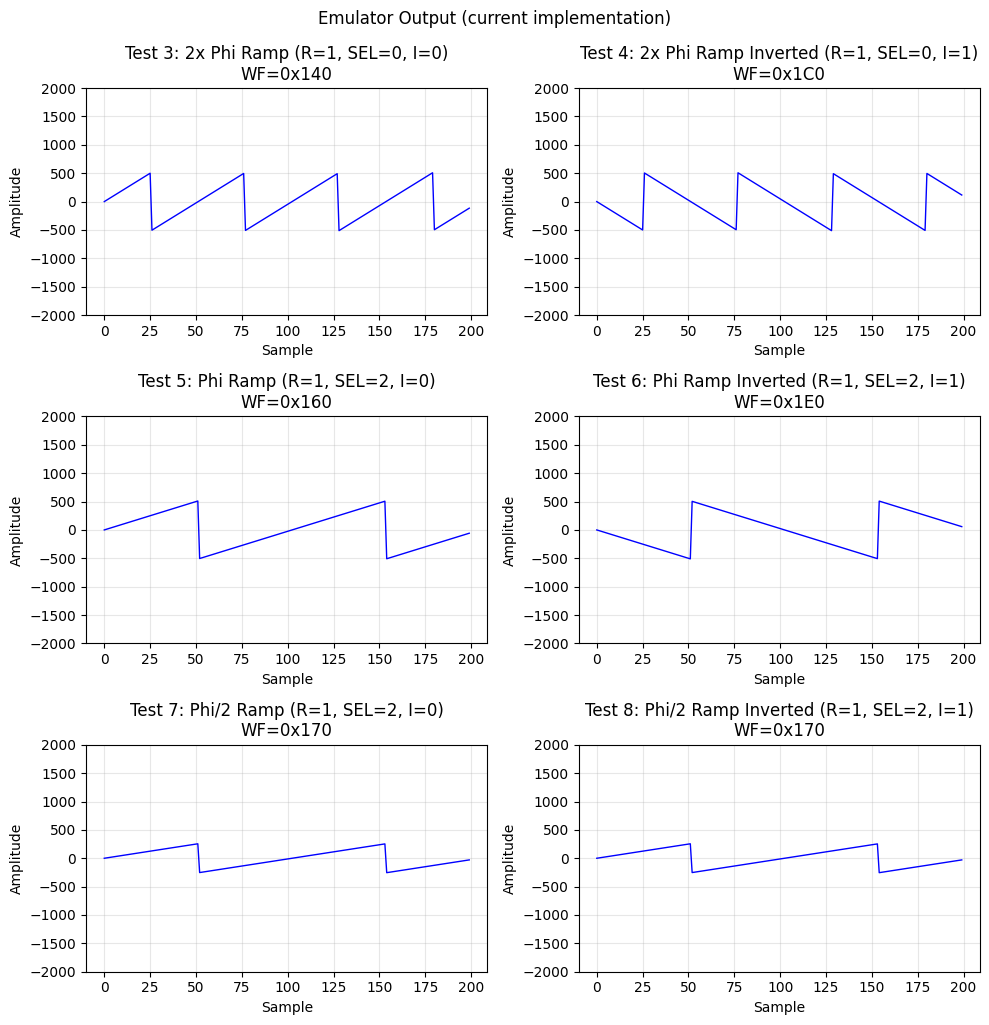


Generated 6 test algorithms


In [40]:
# Generate and run all test algorithms in emulator
results = {}

sam = SAM8905Interpreter()
num_samples = 500  # Enough to see a few periods

#fig, axes = plt.subplots(5, 2, figsize=(24, 8))
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, cfg in enumerate(test_configs):
    # Generate algorithm
    aram, dram = make_test_algorithm(cfg['wf'], freq_hz=440)
    
    if aram is None:
        print(f"Failed to generate {cfg['name']}")
        continue
    
    # Reset and load
    sam.reset()
    sam.load_aram(aram, offset=0)
    sam.load_dram(0, dram)
    
    # Run
    samples = sam.run(num_samples, active_slots=[0])
    results[cfg['name']] = {
        'config': cfg,
        'aram': aram,
        'dram': dram,
        'samples': samples
    }
    
    # Plot
    ax = axes[idx]
    ax.plot(samples[:200, 0], 'b-', linewidth=1)
    ax.set_title(f"{cfg['name']}\nWF=0x{cfg['wf']:03X}")
    ax.set_xlabel('Sample')
    ax.set_ylabel('Amplitude')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-2000, 2000)

plt.tight_layout()
plt.suptitle("Emulator Output (current implementation)", y=1.02)
plt.show()

print(f"\nGenerated {len(results)} test algorithms")

## Hardware Programming Data

The following sections show the exact A-RAM and D-RAM values to program into real hardware for each test.

In [5]:
# Output programming data for each test
for name, data in results.items():
    cfg = data['config']
    aram = data['aram']
    dram = data['dram']
    
    print("=" * 70)
    print(f"  {name}")
    print("=" * 70)
    print(f"WF = 0x{cfg['wf']:03X} (R={cfg['r']}, I={cfg['i']})")
    print()
    
    # A-RAM (algorithm)
    print("A-RAM (32 x 15-bit words):")
    print("  ", end="")
    for i, word in enumerate(aram):
        print(f"0x{word:04X}", end=", " if i < len(aram)-1 else "")
        if (i + 1) % 8 == 0 and i < len(aram)-1:
            print("\n  ", end="")
    print()
    print()
    
    # Disassembly
    print("Disassembly:")
    for pc, word in enumerate(aram[:10]):  # First 10 instructions
        di = decode_instruction(word)
        from sam8905_aram_decoder import format_instruction
        print(f"  PC{pc:02d}: {word:04X}  {format_instruction(di)}")
    print("  ...")
    print()
    
    # D-RAM
    print("D-RAM Slot 0 (16 x 19-bit words):")
    for i, word in enumerate(dram):
        if word != 0 or i in [0, 1, 2, 3, 15]:  # Show important words
            print(f"  D[{i:2d}] = 0x{word:05X}", end="")
            if i == 0: print("  ; PHI (phase)")
            elif i == 1: print("  ; DPHI (phase increment)")
            elif i == 2: print(f"  ; WF config -> WF=0x{(word >> 9) & 0x1FF:03X}")
            elif i == 3: print("  ; Amplitude + mix")
            elif i == 15: print("  ; Control (ALG, IDLE)")
            else: print()
    print()
    print()

  Test 1: R=0 I=0 (baseline)
WF = 0x100 (R=0, I=0)

A-RAM (32 x 15-bit words):
  0x10FD, 0x006F, 0x08BF, 0x19F7, 0x02DF, 0x06FF, 0x06FF, 0x06FE, 
  0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 
  0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 
  0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF

Disassembly:
  PC00: 10FD  10FD  RM 2, <WWF>
  PC01: 006F  006F  RM 0, <WA, WPHI>
  PC02: 08BF  08BF  RM 1, <WB>
  PC03: 19F7  19F7  RM 3, <WXY, WSP>
  PC04: 02DF  02DF  RADD 0, <WM>
  PC05: 06FF  06FF  RSP, <NOP>
  PC06: 06FF  06FF  RSP, <NOP>
  PC07: 06FE  06FE  RSP, <WACC>
  PC08: 06FF  06FF  RSP, <NOP>
  PC09: 06FF  06FF  RSP, <NOP>
  ...

D-RAM Slot 0 (16 x 19-bit words):
  D[ 0] = 0x00000  ; PHI (phase)
  D[ 1] = 0x01400  ; DPHI (phase increment)
  D[ 2] = 0x20000  ; WF config -> WF=0x100
  D[ 3] = 0x20000  ; Amplitude + mix
  D[15] = 0x00000  ; Control (ALG, IDLE)


  Test 2: R=0 I=1
WF = 0x110 (R=0, I=1)

A-RAM (32 x 15-bit words):
  0x10

## Combined Sequential Test

A single algorithm that cycles through all R/I combinations, making it easy to record from hardware and identify each mode by timing.

In [6]:
# Create a multi-slot test: Each slot uses a different WF configuration
# Slots 0-3 run simultaneously with different WF values
# Use different frequencies so they're distinguishable

multi_slot_configs = [
    {"slot": 0, "wf": 0x100, "freq": 440, "name": "R=0 I=0 @ 440Hz"},
    {"slot": 1, "wf": 0x110, "freq": 550, "name": "R=0 I=1 @ 550Hz"},
    {"slot": 2, "wf": 0x120, "freq": 660, "name": "R=1 I=0 @ 660Hz"},
    {"slot": 3, "wf": 0x130, "freq": 880, "name": "R=1 I=1 @ 880Hz"},
]

# Generate shared A-RAM (all slots use same algorithm at ALG 0)
base_aram, _ = make_test_algorithm(0x100, freq_hz=440)  # WF will be overridden by D-RAM

# Create D-RAM for each slot
multi_dram = {}
for cfg in multi_slot_configs:
    phase_inc = make_phase_increment(cfg['freq'], 44100)
    amplitude = 0x300
    mix_l, mix_r = 0, 0  # Full volume
    
    dram = [0] * 16
    dram[0] = 0  # PHI
    dram[1] = phase_inc << 7  # DPHI
    dram[2] = make_wf_config_dram(cfg['wf'])  # WF config
    dram[3] = make_amplitude_word(amplitude, mix_l, mix_r)
    dram[15] = 0  # ALG=0, IDLE=0
    
    multi_dram[cfg['slot']] = dram
    print(f"Slot {cfg['slot']}: {cfg['name']}")
    print(f"  WF = 0x{cfg['wf']:03X}, DPHI = {phase_inc}")
    print(f"  D[2] = 0x{dram[2]:05X}")
    print()

print("Multi-slot configuration ready")

Slot 0: R=0 I=0 @ 440Hz
  WF = 0x100, DPHI = 40
  D[2] = 0x20000

Slot 1: R=0 I=1 @ 550Hz
  WF = 0x110, DPHI = 51
  D[2] = 0x22000

Slot 2: R=1 I=0 @ 660Hz
  WF = 0x120, DPHI = 61
  D[2] = 0x24000

Slot 3: R=1 I=1 @ 880Hz
  WF = 0x130, DPHI = 81
  D[2] = 0x26000

Multi-slot configuration ready


In [ ]:
# Run multi-slot test in emulator
sam = SAM8905Interpreter()

# Load shared A-RAM
sam.load_aram(base_aram, offset=0)

# Load D-RAM for each slot
for slot, dram in multi_dram.items():
    sam.load_dram(slot, dram)

# Run with all 4 slots active
active_slots = [cfg['slot'] for cfg in multi_slot_configs]
samples = sam.run(2000, active_slots=active_slots)

# Plot combined output
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Full output
ax1 = axes[0]
ax1.plot(samples[:, 0], 'b-', linewidth=0.5, label='Left')
ax1.plot(samples[:, 1], 'r-', linewidth=0.5, alpha=0.5, label='Right')
ax1.set_title("Combined Output (4 slots, different WF and frequencies)")
ax1.set_xlabel('Sample')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoomed view
ax2 = axes[1]
ax2.plot(samples[:500, 0], 'b-', linewidth=1)
ax2.set_title("Zoomed View (first 500 samples)")
ax2.set_xlabel('Sample')
ax2.set_ylabel('Amplitude')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOutput range: L=[{samples[:,0].min():.0f}, {samples[:,0].max():.0f}]")

## C Header Output for Test Firmware

Export data as C arrays for use in 8051 test firmware.

In [7]:
# Generate C header for test firmware
def generate_c_header(aram, dram_slots, test_name="wf_test"):
    """Generate C header with test data."""
    lines = []
    lines.append(f"// SAM8905 WF Bit Test Data")
    lines.append(f"// Generated from hardware_test_wf_bits.ipynb")
    lines.append(f"")
    lines.append(f"#ifndef {test_name.upper()}_H")
    lines.append(f"#define {test_name.upper()}_H")
    lines.append(f"")
    
    # A-RAM (15-bit words stored as uint16_t)
    lines.append(f"// A-RAM: {len(aram)} x 15-bit instructions")
    lines.append(f"static const uint16_t test_aram[{len(aram)}] = {{")
    for i in range(0, len(aram), 8):
        chunk = aram[i:i+8]
        hex_vals = ", ".join(f"0x{w:04X}" for w in chunk)
        lines.append(f"    {hex_vals},")
    lines.append(f"}};")
    lines.append(f"")
    
    # D-RAM for each slot (19-bit words, stored as uint32_t)
    for slot, dram in dram_slots.items():
        lines.append(f"// D-RAM Slot {slot}: 16 x 19-bit words")
        lines.append(f"static const uint32_t test_dram_slot{slot}[16] = {{")
        for i in range(0, 16, 4):
            chunk = dram[i:i+4]
            hex_vals = ", ".join(f"0x{w:05X}" for w in chunk)
            lines.append(f"    {hex_vals},")
        lines.append(f"}};")
        lines.append(f"")
    
    lines.append(f"#endif // {test_name.upper()}_H")
    
    return "\n".join(lines)

# Generate header for multi-slot test
header = generate_c_header(base_aram, multi_dram, "wf_bit_test")
print(header)

// SAM8905 WF Bit Test Data
// Generated from hardware_test_wf_bits.ipynb

#ifndef WF_BIT_TEST_H
#define WF_BIT_TEST_H

// A-RAM: 32 x 15-bit instructions
static const uint16_t test_aram[32] = {
    0x10FD, 0x006F, 0x08BF, 0x19F7, 0x02DF, 0x06FF, 0x06FF, 0x06FE,
    0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF,
    0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF,
    0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF, 0x06FF,
};

// D-RAM Slot 0: 16 x 19-bit words
static const uint32_t test_dram_slot0[16] = {
    0x00000, 0x01400, 0x20000, 0x18000,
    0x00000, 0x00000, 0x00000, 0x00000,
    0x00000, 0x00000, 0x00000, 0x00000,
    0x00000, 0x00000, 0x00000, 0x00000,
};

// D-RAM Slot 1: 16 x 19-bit words
static const uint32_t test_dram_slot1[16] = {
    0x00000, 0x01980, 0x22000, 0x18000,
    0x00000, 0x00000, 0x00000, 0x00000,
    0x00000, 0x00000, 0x00000, 0x00000,
    0x00000, 0x00000, 0x00000, 0x00000,
};

// D-RAM Slot 2: 16 x 19-bit words
stat

## Hardware Testing Instructions

### Setup
1. Compile test firmware with the generated header
2. Burn to EPROM and install in Keyfox10
3. Connect audio output to recording interface

### Recording
1. Power on and wait for test to start
2. Record audio for ~5 seconds
3. Save as WAV file

### Analysis
1. Load recorded WAV into this notebook
2. Compare waveform shapes to emulator predictions
3. Determine which R/I bit interpretation matches hardware

### Expected Results

If **manual is correct** (R=bit5, I=bit4):
- Test 2 (I=1): Inverted amplitude (negative of Test 1)
- Test 3 (R=1): Reversed phase (plays backwards)

If **bits are swapped** (R=bit4, I=bit5):
- Test 2: Reversed phase
- Test 3: Inverted amplitude

### Key Visual Differences

| Effect | Waveform appearance |
|--------|---------------------|
| Normal sine | Starts at 0, rises first |
| Inverted | Starts at 0, falls first |
| Reversed | Same shape, but phase offset |
| Reversed + Inverted | Equivalent to 180° phase shift |